# 1.1 Convolutional Neural Network for Regression - Transfer Learning

In this demo code, we will:

<ul>
<li>Explore if the regression model in 1.0 can be used for transfer learning.</li>  
<li>Visualize the filter activations (intermediate representations) when the CNN is used in a "transfer" setting.</li>
</ul>

In [2]:
import pandas as pd
from sklearn.decomposition import PCA

#load MNIST dataset 
%matplotlib inline
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
#plot function for sample images

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('viridis'), aspect='auto')

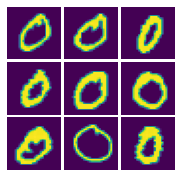

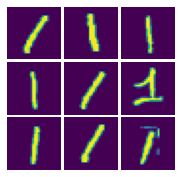

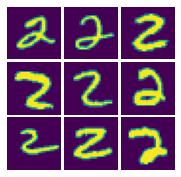

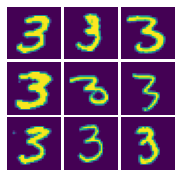

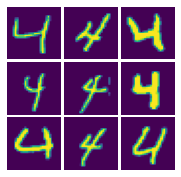

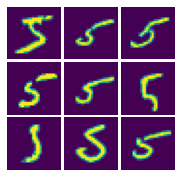

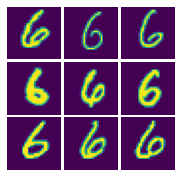

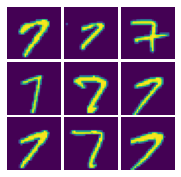

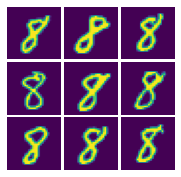

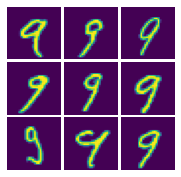

In [4]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [5]:
#create (simulate) a synthetic "time series" data vector (y) for each of the input (x) such that y=Gx and G is linear

#G represents some abstract function (i.e. fluid flow simulator)
G = np.load('G.npy')

y_dim = G.shape[-1]
y_reg_train = np.zeros([y_train.shape[0], y_dim])
y_reg_test = np.zeros([y_test.shape[0], y_dim])

#simulate Y = GX
for i in range(y_train.shape[0]):
    y_reg_train[i:i+1, :] = np.reshape((x_train[i:i+1, :, :, 0]), [1, x_train.shape[1]*x_train.shape[2]])@G

for i in range(y_test.shape[0]):
    y_reg_test[i:i+1, :] = np.reshape((x_test[i:i+1, :, :, 0]), [1, x_test.shape[1]*x_test.shape[2]])@G

print(y_reg_train.shape)
print(y_reg_test.shape)

(60000, 128)
(10000, 128)


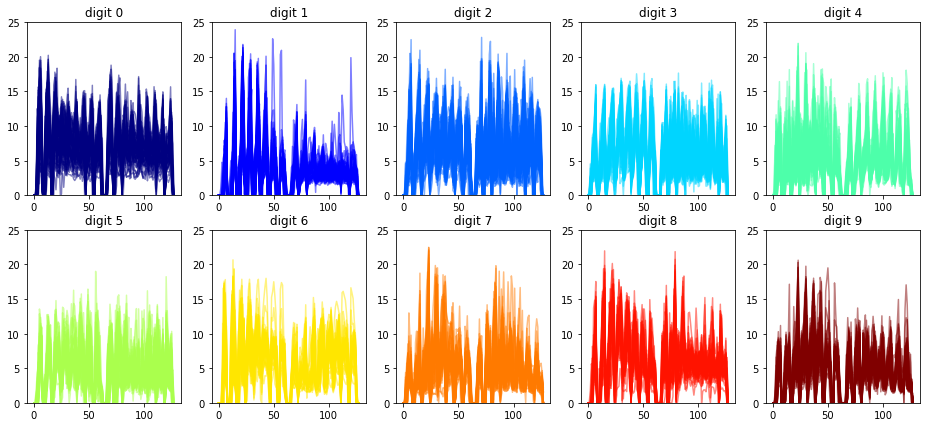

In [6]:
#visualize the generated signals (for training dataset) 

import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (16, 7))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_train))

for j in range(10):
    plt.subplot(2, 5, j+1)
    for i in range(500):
        if (y_train[i] == j):
            plt.plot(y_reg_train[i, :], c=cs[i], alpha=0.5)
    plt.ylim([0, 25])
    plt.title('digit '+str(j))

In [9]:
#split label 2 (transfer) and 8, 9 (original)

x_train_original = x_train[y_train >= 8]
x_train_transfer = x_train[y_train == 2]

x_test_original = x_test[y_test >= 8]
x_test_transfer = x_test[y_test == 2]

y_reg_train_original = y_reg_train[y_train >= 8]
y_reg_train_transfer = y_reg_train[y_train == 2]

y_reg_test_original = y_reg_test[y_test >= 8]
y_reg_test_transfer = y_reg_test[y_test == 2]

print(x_train_original.shape)
print(x_test_original.shape)

print(x_train_transfer.shape)
print(x_test_transfer.shape)

print(y_reg_train_original.shape)
print(y_reg_test_original.shape)

print(y_reg_train_transfer.shape)
print(y_reg_test_transfer.shape)

(11800, 28, 28, 1)
(1983, 28, 28, 1)
(5958, 28, 28, 1)
(1032, 28, 28, 1)
(11800, 128)
(1983, 128)
(5958, 128)
(1032, 128)


In [10]:
#define a regression model with Keras 

import keras
from keras.models import Model

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import Input, LeakyReLU, Reshape
from keras import backend as K

from keras.optimizers import Adam
from IPython.display import clear_output
from keras.callbacks import History 

#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

Using TensorFlow backend.


In [11]:
#define the convolutional neural network architecture

input_img = Input(shape=(x_train.shape[1], x_train.shape[1], 1)) 

_ = Conv2D(8, (3, 3), activation='linear', padding='same')(input_img)
_ = LeakyReLU(alpha=0.3)(_)
f1 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(16, (4, 4), activation='linear', padding='same')(f1)
_ = LeakyReLU(alpha=0.3)(_)
f2 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(32, (5, 5), activation='linear', padding='same')(f2)
_ = LeakyReLU(alpha=0.8)(_)
f3 = MaxPooling2D((2, 2), padding='same')(_)

_ = Reshape((16*32,))(f3)
_ = Dense(16)(_)
f4 = LeakyReLU(alpha=0.3)(_)

_ = Dense(32)(f4)
_ = LeakyReLU(alpha=0.3)(_)

_ = Dense(64)(_)
_ = LeakyReLU(alpha=0.3)(_)

out = Dense(128)(_)

In [12]:
#set loss function, optimizer and compile

regression = Model(input_img, out)
opt = keras.optimizers.Adam(lr=1e-4)
regression.compile(optimizer=opt, 
                   loss="mse", 
                   metrics=['mse'])

#get summary of architecture parameters and plot arch. diagram
regression.summary()
from keras.utils import plot_model
plot_model(regression, to_file='regression.png')

plot_losses = PlotLosses()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2064      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________

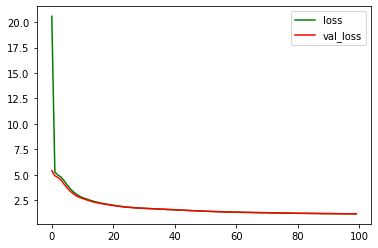

In [13]:
#train the neural network

regression.fit(x_train_original, y_reg_train_original,        
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [ ]:
#save and load the trained model

#regression.save('regression.h5')

#from keras.models import load_model
#regression = load_model('regression.h5')

In [14]:
#get the predictions for the train dataset (original split)
y_reg_train_original_hat = regression.predict(x_train_original)

#get the predictions for the test dataset
y_reg_test_original_hat = regression.predict(x_test_original)

Text(0.5, 1.0, 'Train dataset')

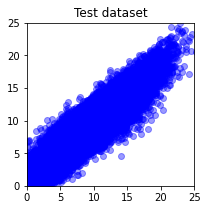

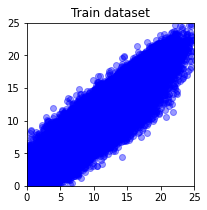

In [15]:
#check the prediction vs actual data (original split)
plt.figure(figsize=[3, 3])
plt.scatter(y_reg_test_original.flatten(), y_reg_test_original_hat.flatten(), alpha=0.4, c='blue')
plt.xlim([0, 25])
plt.ylim([0, 25])
plt.title('Test dataset')

plt.figure(figsize=[3, 3])
plt.scatter(y_reg_train_original.flatten(), y_reg_train_original_hat.flatten(), alpha=0.4, c='blue')
plt.xlim([0, 25])
plt.ylim([0, 25])
plt.title('Train dataset')

In [20]:
#used the trained model (on original split) to predict for transfer split

#get the predictions for the test dataset (transfer split)
y_reg_test_transfer_hat = regression.predict(x_test_transfer)

#report the rmse
print("RMSE value is = %.3f" %np.sqrt(np.mean((y_reg_test_transfer-y_reg_test_transfer_hat)**2)))

RMSE value is = 1.868


In [35]:
#create a transfer regressor, initialized with the trained weights, fix the weights of conv layers

#check the trainable status of the individual layers
for layer in regression.layers:
    print(layer, layer.trainable)
    
#freeze all the layers
for layer in regression.layers:
    layer.trainable = False
    
#allow the last two layers to be retrained
for i in range(11, 18):
    regression.layers[i].trainable = True
    
#check the trainable status of the individual layers
for layer in regression.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000016BC10F27B8> False
<keras.layers.convolutional.Conv2D object at 0x0000016BC10F2780> False
<keras.layers.advanced_activations.LeakyReLU object at 0x0000016BC10F2D68> False
<keras.layers.pooling.MaxPooling2D object at 0x0000016BC10F2C88> False
<keras.layers.convolutional.Conv2D object at 0x0000016BC10F2A20> False
<keras.layers.advanced_activations.LeakyReLU object at 0x0000016BC1106278> False
<keras.layers.pooling.MaxPooling2D object at 0x0000016BC1130908> False
<keras.layers.convolutional.Conv2D object at 0x0000016BC1130A90> False
<keras.layers.advanced_activations.LeakyReLU object at 0x0000016BC1130D68> False
<keras.layers.pooling.MaxPooling2D object at 0x0000016BC1265470> False
<keras.layers.core.Reshape object at 0x0000016BC1265E48> False
<keras.layers.core.Dense object at 0x0000016BC127A438> True
<keras.layers.advanced_activations.LeakyReLU object at 0x0000016BC1265390> True
<keras.layers.core.Dense object at 0x0000016BC129A668> 

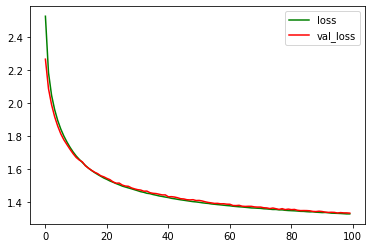

In [36]:
#re-train the neural network on the transfer dataset

regression.fit(x_train_transfer, y_reg_train_transfer,        
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [37]:
#used the re-trained model (on transfer split) to predict for transfer split

#get the predictions for the test dataset (transfer split)
y_reg_test_transfer_hat_retrained = regression.predict(x_test_transfer)

#report the rmse
print("RMSE value is = %.3f" %np.sqrt(np.mean((y_reg_test_transfer-y_reg_test_transfer_hat_retrained)**2)))

RMSE value is = 1.136


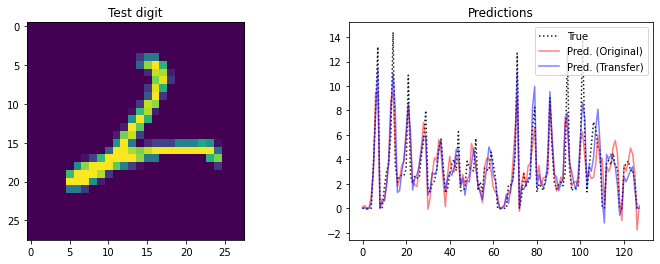

In [51]:
#functions to plot testing data and the predictions (vs actual data)
#to compare original model (trained on 8,9) vs "transferred" model (retrained with 2)

test_case = 3

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.imshow(x_test_transfer[test_case, :, :, 0])
plt.title('Test digit')

plt.subplot(1, 2, 2)
plt.plot(y_reg_test_transfer[test_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_transfer_hat[test_case, :], c='r', label='Pred. (Original)', alpha=0.5)
plt.plot(y_reg_test_transfer_hat_retrained[test_case, :], c='b', label='Pred. (Transfer)', alpha=0.5)
#plt.ylim([0, 25])
plt.title('Predictions')
plt.legend()